## Issue Resolution
This is the reference implementation for [Issue Resolution Duration](https://github.com/chaoss/wg-evolution/blob/master/metrics/Issue_Resolution_Duration.md), 
a metric specified by the
[Evolution Working Group](https://github.com/chaoss/wg-evolution) of the
[CHAOSS project](https://chaoss.community).

Have a look at [README.md](../README.md) to find out how to run this notebook (and others in this directory) as well as to get a better understanding of the purpose of the implementations.

The implementation is described in two parts (see below):

* Class for computing Issue Resolution Duration
* An explanatory analysis of the class' functionality

Some more auxiliary information in this notebook:

* Examples of the use of the implementation

As discussed in the [README](../README.md) file, the scripts required to analyze the data fetched by Perceval are located in the `scripts` package. Due to python's import system, to import modules from a package which is not in the current directory, we have to either add the package to `PYTHONPATH` or simply append a `../..` to `sys.path`, so that `scripts` can be successfully imported. 

In [21]:
from datetime import datetime
import matplotlib.pyplot as plt

import sys
sys.path.append('../..')

from implementations.code_df.issue_github import IssueGitHub
from implementations.code_df.utils import str_to_date, read_json_file
%matplotlib inline

In [22]:
class IssueResolutionDurationGithub(IssueGitHub):
    """
    Class for the Issue Resolution Duration metric.
    """

    def _flatten(self, item):
        """
        Flatten a raw issue fetched by Perceval into a flat dictionary.

        A list with a single flat directory will be returned.
        That dictionary will have the elements we need for computing metrics.
        The list may be empty, if for some reason the issue should not
        be considered.

        :param item: raw item fetched by Perceval (dictionary)
        :returns:   list of a single flat dictionary
        """
        flat = super()._flatten(item)

        if flat:
            flat = flat[0]
        else:
            return flat

        if flat['current_status'] != 'closed':
            return []

        closed_date = str_to_date(item['data']['closed_at'])
        flat.update(
            closed_date=closed_date,
            resolution_duration=(closed_date - flat['created_date']).days)

        return [flat]

    def compute(self):
        """
        Compute the average of issue resolution duration for all issues in the Perceval data.

        :returns: the average of issue resolution duration
        """
        return self.df['resolution_duration'].mean()

    def compute_max(self):
        return self.df['resolution_duration'].max(skipna=True)

    def compute_min(self):
        return self.df['resolution_duration'].min(skipna=True)

    def _agg(self, df, period):
        """
        Perform an aggregation operation on a DataFrame to find
        the average age of issues created in a every
        interval of the period specified in the time_series method,
        like 'M', 'W',etc.

        It computes the mean of the 'open_issue_age' column of the
        DataFrame.

        :param df: a pandas DataFrame on which the aggregation will be
            applied.

        :param period: A string which can be any one of the pandas time
            series rules:
            'W': week
            'M': month
            'D': day

        :returns df: The aggregated dataframe, where aggregations have
            been performed on the "resolution_duration" column
        """
        df = df.resample(period)['resolution_duration'].agg(['mean'])
        df = df.dropna()

        return df

    def _get_params(self):
        """
        Return parameters for creating a timeseries plot

        :returns: A dictionary with axes to plot, a title
            and if use_index should be true when creating
            the plot.
        """
        title = "Trends in Issue Resolution Duration"
        x = None
        y = 'mean'
        use_index = True
        return {'x': x, 'y': y, 'title': title, 'use_index': use_index}

    def __str__(self):
        return "Issue Resolution Duration"

## Performing the Analysis
We'll perform two kinds of analysis here:
- Counting the average age of open issues
- Change of average open issue age over time

### Computing the average resolution duration of issues
First, we read the JSON file `issues.json`, present in the `implementations` directory, one level up. We make use of the `read_json_file` utility function.

In [23]:
items = read_json_file('../issues.json')

Let's use the `compute` method to compute to calculate the average of resolution duration of issues. First, we will do it without passing any since and until dates. 
Next, we can pass in the start and end dates as a tuple. The format would be `%Y-%m-%d`.

Lets calculate the average age for all open issues first. Then, we can do it by passing a start date. Here, only those issues will be considered that were created after the start date we passed via the variable `date_since`. 

While printing the output, we will keep the precision to only two decimals. 

In [24]:
date_since = datetime.strptime("2018-09-07", "%Y-%m-%d")
issue_resolution_duration = IssueResolutionDurationGithub(items)
print('The average resolution duration of all issues is {:.2f} days.'.format(issue_resolution_duration.compute()))

issue_resolution_duration = IssueResolutionDurationGithub(items, (date_since, None))
print('The average resolution duration of issues created after 2018-09-07 is {:.2f} days.'.format(issue_resolution_duration.compute()))

The average resolution duration of all issues is 22.47 days.
The average resolution duration of issues created after 2018-09-07 is 9.73 days.


## Average age of open issues over time
Using the `timeseries` method, we can see how the average age of open issues changes on every periodic interval of time. This interval can be a week, a month or any other valid pandas timeseries period.  This kind of analysis is useful in finding trends over time, as we will see in the cell below.

Lets use the `open_issue_age_interval` object we created above, where we passed an opening date to the object via `date_since`.

In [25]:
weekly_df = issue_resolution_duration.time_series('W')

Lets see what the dataframe returned by `timeseries` looks like. As you will notice, the dataframe has rows corresponding to each and every week between the start and end dates. To do this, we simply set the `created_date` column of the DataFrame `issue_resolution_duration.df`, as its index and then `resample` it to whatever time period we need. In this case, we have used `W`.  

In [26]:
weekly_df

,mean
created_date,
2018-09-09,0.000000
2018-09-16,19.500000
2018-09-23,38.800000
2018-09-30,0.000000
2018-10-07,7.600000
2018-10-28,13.500000
2018-11-11,0.000000
2018-11-18,0.000000
2018-11-25,8.666667


Lets plot the dataframe `weekly_df` using matplotlib.pyplot. We use the `seaborn` theme and plot a simple line plot --- average open issue age vs time interval. Using the `plt.fill_between` method allows us to "fill up" the area between the line plot and the x axis.

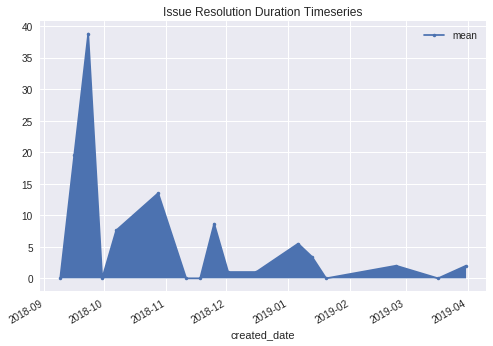

In [33]:
plt.style.use('seaborn')
weekly_df.plot(y='mean', use_index=True, marker='.')
plt.fill_between(y1=weekly_df['mean'], y2=0, x=weekly_df.index)
plt.title("Issue Resolution Duration Timeseries");

We can do the same thing on a monthly basis. As can be expected, the resulting DataFrame, `monthly_df` would have a lesser number of datapoints when compared to `weekly_df`, due to the larger period being considered.

In [0]:
monthly_df = issue_resolution_duration.time_series('M')

In [0]:
monthly_df

As predicted, the `monthly_df` dataframe has significantly lesser rows than the dataframe we just observed --- `weekly_df`. Each row corresponds to a month between the `since` and `until` finish dates we passed to while instantiating the `IssueResolutionDuration` class.  

Lets do one last thing: plot the graph for `monthly_df`. 

In [0]:
plt.style.use('seaborn')
monthly_df.plot(y='issue_resolution_duration', use_index=True, marker='.')
plt.title("Average Issue Resolution Duration");